# Вступление

Работу налепили Князева Мария и Сюй Алиса под четким контролем Парисенковой Елизаветы. Мы работали с датасетом "Русский рэп с 2017 по 2022 год", крутили и вертели его как могли, и хотим поделиться нашем горе-результатом.



<img src='https://sun9-66.userapi.com/impg/6Lr7u2j6NFdVAIcN0CKNXga2UY8Ewkk_MIUL5A/Nae7PjPHrXU.jpg?size=946x926&quality=96&sign=286653951d3969940f46404c9a3d1472&type=album' width='500'>

In [69]:
import requests
from requests.auth import HTTPProxyAuth
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt

# Сбор Данных (Парсим продолжительность песни)

In [70]:
pd.set_option('display.max_columns', 30)  # установим нужный размер отображения таблицы

In [71]:
df = pd.read_csv('/content/Five_years_of_Russian_Rap_Dataset (1).csv')
df.head()

,track_id,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,status_guest,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,artist_id,album_id,download_link
0,5OFMeePbu2eEX1Hyf2tzYj,044 ROSE,hit,2017-06-23,0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,True,1,"0,1",1,ФОРМУЛА 1,single,1,True,G#,major,G# major,LIL MORTY; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,4lsz5FpE3SFVuniECODcNN,https://p.scdn.co/mp3-preview/c37091967a02a815...
1,29kkmN00FdzizRg5xrVmBF,044 ROSE,none,2017-12-08,1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,True,1,1,0,Mandolina (feat. 044 ROSE),single,1,True,C,major,C major,ВАЙС; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,6jnftxbUPDmmpOgt9gdvFb,https://p.scdn.co/mp3-preview/04d4f628d8305b88...
2,7L1tQKY6mcy0sGXntrABgW,044 ROSE,none,2018-02-13,1,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,False,0,NaN,0,Альбом 044,album,1,True,B,major,B major,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/a257eed4179821af...
3,4jwDiUBqLQCCuyWkbX87qN,044 ROSE,none,2018-02-13,1,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,True,1,"1,2",1,Альбом 044,album,2,True,G#,major,G# major,044 ROSE; LIL MORTY,original,2V8aJ7qCArKAmHAX7u81Sj,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/91fedfb65d95d8bd...
4,2DYUk5AkUV7kPTvd58LVCw,044 ROSE,none,2018-02-13,1,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,False,0,NaN,0,Альбом 044,album,3,True,B,minor,B minor,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/e312514b3efa7d10...


In [72]:
# извлекаем айди песен (пригодится для поиска)
track_id = df['track_id'].unique()
len(track_id)

12743

Уникальных айдишек меньше чем строк в датасете, потому что фиты встречаются по несколько раз (при анализе это будет учтено). Фиты расписаны по каждому артисту, например:


In [73]:
df[['track_id', 'is_feat', 'album_name', 'artist_name', 'artists_all']][df['track_id'] == '5OFMeePbu2eEX1Hyf2tzYj']

,track_id,is_feat,album_name,artist_name,artists_all
0,5OFMeePbu2eEX1Hyf2tzYj,True,ФОРМУЛА 1,044 ROSE,LIL MORTY; 044 ROSE
5673,5OFMeePbu2eEX1Hyf2tzYj,True,ФОРМУЛА 1,LIL MORTY,LIL MORTY; 044 ROSE


###**Приступаем непосредственно к парсингу :**

Интересный факт: пока ждёшь конца парсинга, можно успеть слетать до Грузии (а мб и обратно)

In [74]:
def skam(link):
  # задаем прокси, чтобы никто не узнал откуда мы
  proxies = {'http': 'http://146.247.117.207:8161'}
  auth = HTTPProxyAuth('user180567', 'nae7rp')

  # получаем доступ к сайту
  response = requests.get(
  url=link,
  proxies=proxies,
  auth=auth,
  timeout=30,
  )
  return response

In [75]:
# Сюда отправляются ссылки, который первый раз не прошли
def parsing_again(lol):
  soup = BeautifulSoup(skam(lol).content, 'html.parser')
  time.sleep(0.5)
  song_time = soup.find_all('span')
  if len(song_time) < 3:
    return 'None'
  else:
    return song_time[2].text

In [76]:
def song_parsing(i):
  song_link = 'https://open.spotify.com/track/' + i
  soup = BeautifulSoup(skam(song_link).content, 'html.parser')
  time.sleep(0.5)
  song_time = soup.find_all('span')
  if len(song_time) < 3:
    return parsing_again(song_link)
  else:
    return song_time[2].text

Запускаем и ждём 3ч. 40мин.:

In [77]:
# time_d = {i: song_parsing(i)  for i in track_id}

Создаем табличку и сохраняем её в отдельный файл (он будет прикреплён отдельно) - 'song_duration.csv':

In [78]:
# df_time = pd.DataFrame(list(time_d.items()), columns = ['track_id', 'song_duration'])
# df_time.to_csv('song_duration.csv', encoding='utf-8')

###**Соединяем данные**

Мы спарсили длительности песен в минутах. Подгружаем файл с данными

In [79]:
df_time = pd.read_csv('/content/song_duration.csv')
df_time = df_time.drop(['Unnamed: 0'], axis=1)
df_time.head()

,track_id,song_duration
0,5OFMeePbu2eEX1Hyf2tzYj,2:49
1,29kkmN00FdzizRg5xrVmBF,3:16
2,7L1tQKY6mcy0sGXntrABgW,2:07
3,4jwDiUBqLQCCuyWkbX87qN,2:49
4,2DYUk5AkUV7kPTvd58LVCw,2:07


Для начала проверим на наличие ненайденных данных, спойлер: их четыре (пока не понятно как так получилось, в словаре должны были отразиться значения 'None', но их не было ://)


In [80]:
df_time.isnull().sum()

track_id         0
song_duration    4
dtype: int64

исправим:




In [81]:
df_time_non_found = df_time[df_time[['track_id','song_duration']].isnull().any(axis=1)]
df_time_non_found

,track_id,song_duration
3076,61678kM5Gt3uErypuSKwYc,NaN
4448,1U3MfLJ6Fi18dxVGnriVdV,NaN
4449,62QpDyIbfoO7cx12scAdXB,NaN
7609,6YLCUZZDcZzeM0Wyq4ZW76,NaN


In [82]:
for i in df_time_non_found['track_id']:
  inx = df_time_non_found[df_time_non_found['track_id'] == i].index
  df_time.loc[inx,'song_duration'] = song_parsing(i)

df_time.isnull().sum()

track_id         0
song_duration    0
dtype: int64

Вроде все в порядке, но надо проверить нет ли песен с продолжительностью 0:00 и с пустой строкой:

In [83]:
lolol = df_time.loc[(df_time['song_duration'] == '0:00') | (df_time['song_duration'] == '')]
lolol

,track_id,song_duration
3076,61678kM5Gt3uErypuSKwYc,
4448,1U3MfLJ6Fi18dxVGnriVdV,
4449,62QpDyIbfoO7cx12scAdXB,
7609,6YLCUZZDcZzeM0Wyq4ZW76,
10703,1FQXKa6MLD67CSTKu8xlcQ,0:00


Просто уберём их из датасета:

In [84]:
list_drop = lolol.index.to_list()
# df.iloc[list_drop] # тут можно посмотреть на эти треки
df_time = df_time.drop(list_drop) #удаляем
df.shape


(14397, 28)

In [85]:
df = pd.merge(df, df_time, how="left", on ='track_id')
df = df.drop(df[df['song_duration'].isnull() == True].index.tolist()) # не все строки с пропущенным временем удалились, тут удалится ещё 5 где-то
df.head()

,track_id,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,status_guest,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,artist_id,album_id,download_link,song_duration
0,5OFMeePbu2eEX1Hyf2tzYj,044 ROSE,hit,2017-06-23,0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,True,1,"0,1",1,ФОРМУЛА 1,single,1,True,G#,major,G# major,LIL MORTY; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,4lsz5FpE3SFVuniECODcNN,https://p.scdn.co/mp3-preview/c37091967a02a815...,2:49
1,29kkmN00FdzizRg5xrVmBF,044 ROSE,none,2017-12-08,1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,True,1,1,0,Mandolina (feat. 044 ROSE),single,1,True,C,major,C major,ВАЙС; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,6jnftxbUPDmmpOgt9gdvFb,https://p.scdn.co/mp3-preview/04d4f628d8305b88...,3:16
2,7L1tQKY6mcy0sGXntrABgW,044 ROSE,none,2018-02-13,1,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,False,0,NaN,0,Альбом 044,album,1,True,B,major,B major,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/a257eed4179821af...,2:07
3,4jwDiUBqLQCCuyWkbX87qN,044 ROSE,none,2018-02-13,1,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,True,1,"1,2",1,Альбом 044,album,2,True,G#,major,G# major,044 ROSE; LIL MORTY,original,2V8aJ7qCArKAmHAX7u81Sj,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/91fedfb65d95d8bd...,2:49
4,2DYUk5AkUV7kPTvd58LVCw,044 ROSE,none,2018-02-13,1,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,False,0,NaN,0,Альбом 044,album,3,True,B,minor,B minor,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/e312514b3efa7d10...,2:07



<img src='https://sun9-14.userapi.com/impg/qpphauTVFNGjP7vJ6h1L_SdCoZUUQXifwNuzyA/fcDoOYMVilw.jpg?size=930x762&quality=95&sign=6498530db77b64aae073cd938cf1146a&type=album' width='500'>

### **Прибираемся после парсинга**

После парсинга нам уже не нужны некоторые колонки, а именно колонки с айдишниками треков и артистов на Спотифай, удалим их, чтобы табличка выглядела посимпатичней.

In [86]:
df = df.drop(['track_id', 'artist_id', 'album_id', 'download_link'], axis = 1)

Спарсенную продолжительность трека переведем в формат секунд и запишем отдельным признаком, далее будет проверять гипотезы с этим признаком.

In [87]:
# Разделение времени на минуты и секунды
df[['minutes', 'seconds']] = df['song_duration'].str.split(':', expand=True)

# Переводим время в секунды
df['song_duration'] = df['minutes'].astype(int) * 60 + df['seconds'].astype(int)

# удаляем ненужный столбец
df.drop(['seconds', 'minutes'], axis=1, inplace=True)
df.head()

,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,status_guest,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,song_duration
0,044 ROSE,hit,2017-06-23,0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,True,1,"0,1",1,ФОРМУЛА 1,single,1,True,G#,major,G# major,LIL MORTY; 044 ROSE,original,169
1,044 ROSE,none,2017-12-08,1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,True,1,1,0,Mandolina (feat. 044 ROSE),single,1,True,C,major,C major,ВАЙС; 044 ROSE,original,196
2,044 ROSE,none,2018-02-13,1,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,False,0,NaN,0,Альбом 044,album,1,True,B,major,B major,044 ROSE,original,127
3,044 ROSE,none,2018-02-13,1,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,True,1,"1,2",1,Альбом 044,album,2,True,G#,major,G# major,044 ROSE; LIL MORTY,original,169
4,044 ROSE,none,2018-02-13,1,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,False,0,NaN,0,Альбом 044,album,3,True,B,minor,B minor,044 ROSE,original,127


Переводим дату в тип Datetime

In [88]:
df['album_release_date'] = pd.to_datetime(df['album_release_date'], format='%Y-%m-%d')

# 1. Описание датасета




### **Описание признаков**


Мы поделили датасет на смысловые части, так как он нас достаточно обширный, часть признаков, касающихся технических параметров треков, мы рассмотрим по ходу дела чуть ниже, когда будем заниматься визуализацией. А сейчас взглянем на основную информацию:


* artist_name - имя исполнителя
* **Song_Success - категориальный признак: успешность композиции (Таргет)**
* album_release_date - дата релиза альбома
* hit_n - количество хитов ранее у этого исполнителя
* is_feat - является ли трек фитом (Б)
* n_feat - количество приглашенных в фит артистов
* status_guest - количество хитов у гостевых артистов соответственно
* higher_guest - у приглашенного артиста хитов больше чем у того, кто выпустил трек (Б)
* album_name - название альбома
* album_type - single, album или compilation (К)
* track_number - номер трека в альбоме
* explicit - содержит мат (Б)
* key_name - тональность (К)
* mode_name - мажор/минор лад (К)
* artists_all - все артисты в треке
* remake - original/remix (К)
* song_duration - продолжительность трека

(К) - признак категориальный

(Б) - признак бинарный


In [89]:
print(f'Размерность таблицы: {df.shape}')

Размерность таблицы: (14392, 25)


In [90]:
# df.info() здесь информация о типах данных в колонках

### **Заполнение пропусков в признаках**

Посмотрим на пропуски:

In [91]:
df.isnull().sum() # проверка на вшивость

artist_name                          0
Song_Success                         0
album_release_date                   0
hit_n                                0
Drums_Energy                         0
Drums_Complexity                     0
Variety_of_musical_instruments       0
Mixing_Quality                       0
Harmonic_Richness                    0
Mixing_Character                     0
Emotional_Intensity                  0
is_feat                              0
n_feat                               0
status_guest                      8656
higher_guest                         0
album_name                           0
album_type                           0
track_number                         0
explicit                             0
key_name                             8
mode_name                            8
key_mode                             8
artists_all                          0
remake                               0
song_duration                        0
dtype: int64

Пропусков больше половины в колонке status_guest (количество хитов у гостевых артистов), будем линчевать неугодных: признак, к сожалению, попал под раздачу.




In [92]:
df = df.drop('status_guest', axis=1) # удаляем без жалости и сожаления
print(f'Размерность после удаления "status_guest": {df.shape}')

Размерность после удаления "status_guest": (14392, 24)


Так же есть 8 пропусков в признаках key_name, mode_name и key_mode (в одних и тех же строках). Отсутствуют данные о тональности и ладе (мажор/минор) в которых написана музыка.

In [93]:
df_null = df[df['key_name'].isnull() == True]
df_null.head()

,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,song_duration
948,ARTEM SHILOVETS,hit,2021-11-26,1,0.641044,0.589734,1.033366,0.581162,1.195896,0.786624,0.835798,True,3,0,Лифон,single,1,False,NaN,NaN,NaN,nkeeei; uniqe; ARTEM SHILOVETS; SAGARA,original,150
1202,Basta,hit,2021-04-01,22,0.595693,0.588532,0.883543,0.826356,0.621888,0.682805,0.608089,True,3,1,Чернила Осьминога (Deluxe),album,18,False,NaN,NaN,NaN,Kasta; Basta; Rem Digga; Белый Будда,original,263
2061,Dabro,none,2018-12-21,2,0.663588,0.722714,0.664241,0.749423,0.596284,0.599496,0.524139,False,0,0,Только ты,single,1,False,NaN,NaN,NaN,Dabro,original,237
2289,DooMee,none,2020-10-20,1,0.810724,0.577476,0.587169,0.524868,0.653740,0.914242,0.731647,True,1,0,Солнце,single,1,False,NaN,NaN,NaN,vtulka; DooMee,original,181
8046,nkeeei,hit,2021-11-26,1,0.641044,0.589734,1.033366,0.581162,1.195896,0.786624,0.835798,True,3,0,Лифон,single,1,False,NaN,NaN,NaN,nkeeei; uniqe; ARTEM SHILOVETS; SAGARA,original,150


У нас немного пропусков, заполним их модой по каждой колонке

In [94]:
df['key_name'].fillna(df['key_name'].mode()[0], inplace=True)
df['mode_name'].fillna(df['mode_name'].mode()[0], inplace=True)
df['key_mode'].fillna(df['key_mode'].mode()[0], inplace=True)

In [95]:
df.isnull().sum().any()

False

Теперь все пропуски заполнены и мы можем двигаться дальше. Посмотрим на гипотезы:

<img src='https://sun9-52.userapi.com/impg/nnctpr5f02RBRFXMJ4S0gXdVsmYLa85q61v2gw/tjjgSmcYgNA.jpg?size=942x1106&quality=95&sign=5bab0d10cadaaa656a099651116ffe84&type=album' width='500'>

# Гипотезы

Ниже указаны некоторые гипотезы, которые будем проверять:
1. У музыкальных фитов больше шансов стать популярными, чем у треков в соло?
2. Как звуковые характеристики влияют на успешность трека? Что лучше разнообразный трек или жесткий бит 3 минуты норм залетит?
3. Исполнители с большим количеством предыдущих хитов имеют больше шансов на создание нового хита?
4. В разное время года люди предпочитают разные типы музыки (зимой - мажор, летом - минор). В какое время года выходит больше всего хитов?
5. Как номер трека в альбоме влияет на его популярность?





# 2. Визуализация

### 1) Исполнители с большим количеством предыдущих хитов имеют больше шансов на создание успешного нового трека?

In [96]:
df.Song_Success.value_counts(normalize=True) # здесь распределение нашего таргета

Song_Success
none    0.814967
hit     0.185033
Name: proportion, dtype: float64

In [97]:
df_group_hitn = df.groupby(by = 'hit_n').Song_Success.value_counts(normalize = True).unstack()
df_group_hitn.head()

Song_Success,hit,none
hit_n,,
0,0.090577,0.909423
1,0.093604,0.906396
2,0.122505,0.877495
3,0.164165,0.835835
4,0.116939,0.883061


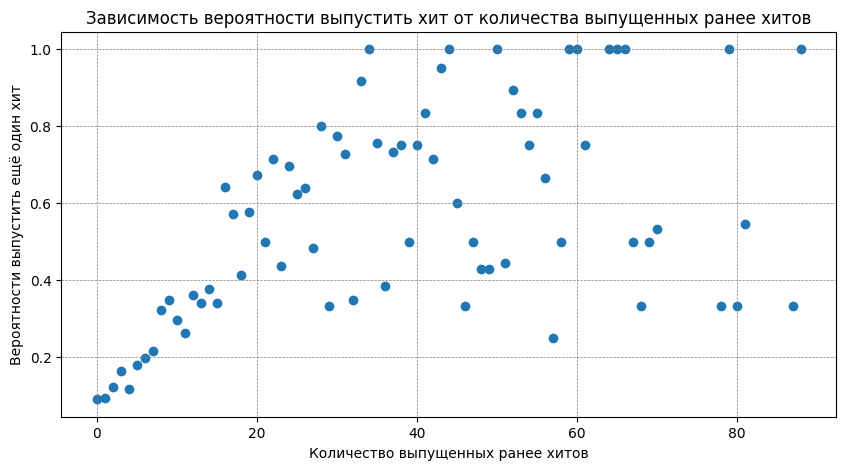

In [98]:
plt.figure(figsize = (10,5))
plt.title('Зависимость вероятности выпустить хит от количества выпущенных ранее хитов')
plt.xlabel('Количество выпущенных ранее хитов')
plt.ylabel('Вероятности выпустить ещё один хит');
plt.scatter(df_group_hitn.index, df_group_hitn.hit)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

Заметно, что чем больше у репера предыдущих хитов, тем выше вероятность написать ещё один хит. В целом начинаем за здравие, очень хочется провести восходящую линию тренда, однако, при слишком большом количестве хитов вероятность успеха колеблется и облако точек расширяется. Это связано с тем, что в датасете мало реперов с большим количеством хитов (см. график ниже):

Можно предположить, что при большей выборке наш признак будет иметь распределение близкое к логарифмическому

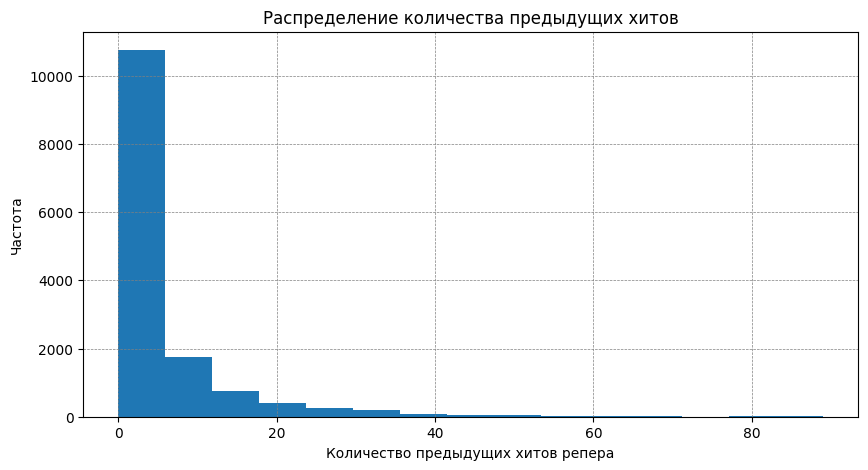

In [99]:
plt.figure(figsize = (10,5))
plt.hist(df.hit_n, bins = 15)
plt.title('Распределение количества предыдущих хитов')
plt.xlabel('Количество предыдущих хитов репера')
plt.ylabel('Частота');
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);


### 2) У музыкальных фитов больше шансов стать популярными, чем у треков в соло?

Мы видим, что большая часть рэпчиков не выстреливает на российской эстраде. Надо бы конкретики выдать, поэтому теперь смотрим, что будет, если добавить еще реперов в трек. Вырастут ли шансы нашей демке залететь? Общую разбивку по таргету (хит или не хит) детализируем с помощью признака is_feat - является ли песня фитом или нет.

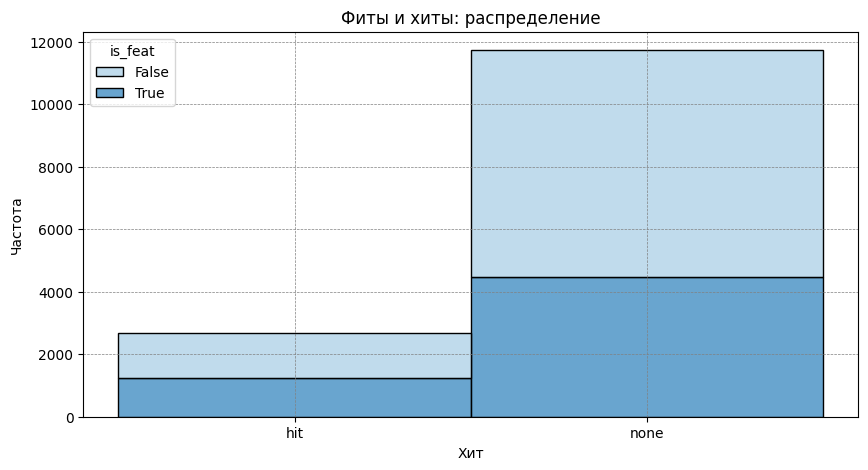

In [100]:
plt.figure(figsize = (10,5))
sns.histplot(x='Song_Success', hue = 'is_feat',data=df, palette = 'Blues', multiple = 'stack')
plt.title('Фиты и хиты: распределение')
plt.xlabel('Хит')
plt.ylabel('Частота')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

По графику видим что мощные бэнгеры примерно в половине случаев записаны коллективно, а еще доля фитов в непопулярных треках меньше, чем если бы трек исполнялся в соло. Покажем это еще и численно:




In [101]:
pd.DataFrame(df.groupby('Song_Success').is_feat.value_counts(normalize=True))

proportion
Song_Success is_feat            
hit          False      0.530229
             True       0.469771
none         False      0.617614
             True       0.382386

### 3) Как успех демки зависит от популярности приглашенного гостя

Если у приглашенного артиста больше хитов, чем у основного исполнитела, то это 1, а если меньше - 0

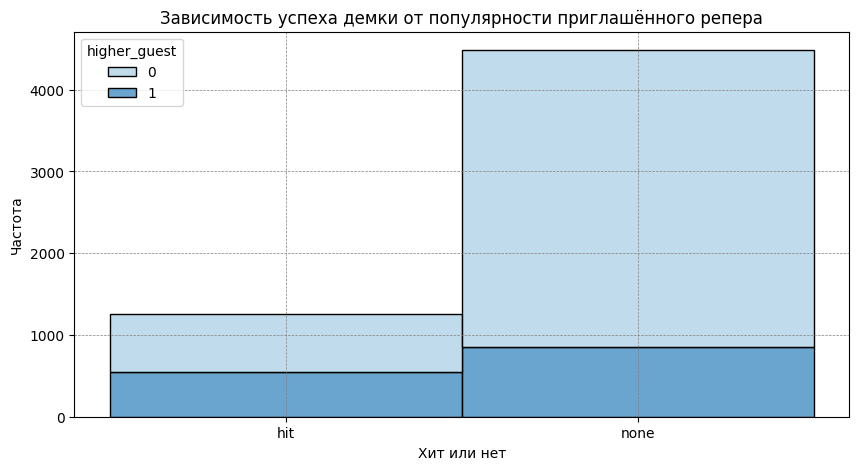

In [102]:
plt.figure(figsize = (10,5))
sns.histplot(x='Song_Success', hue = 'higher_guest',data=df[df['is_feat'] == True], palette = 'Blues', multiple = 'stack')
plt.title('Зависимость успеха демки от популярности приглашённого репера')
plt.xlabel('Хит или нет')
plt.ylabel('Частота')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

In [103]:
pd.DataFrame(df[df['is_feat'] == True].groupby('higher_guest').Song_Success.value_counts(normalize=True))

proportion
higher_guest Song_Success            
0            none            0.837402
             hit             0.162598
1            none            0.609039
             hit             0.390961

По графику и таблице видно, что если пригласить популярного репера (у которого больше выпущенных хитов) на фит, то вероятность успеха трека возрастает.

### 3) Опять анализируем фиты: количество рэперов

В целом коллективным трекам легче стать хитом. Посмотрим на зависимость успеха от количества реперов на фите:





Немного числовых данных:

In [104]:
grouped = df.groupby(by = 'n_feat')['Song_Success']
kek = grouped.value_counts(normalize = True).unstack()
kek['count'] = grouped.count()
kek

Song_Success,hit,none,count
n_feat,,,
0,0.163124,0.836876,8656
1,0.201752,0.798248,4565
2,0.243368,0.756632,867
3,0.379888,0.620112,179
4,0.350649,0.649351,77
5,0.454545,0.545455,11
6,0.500000,0.500000,14
7,0.545455,0.454545,22
8,NaN,1.000000,1


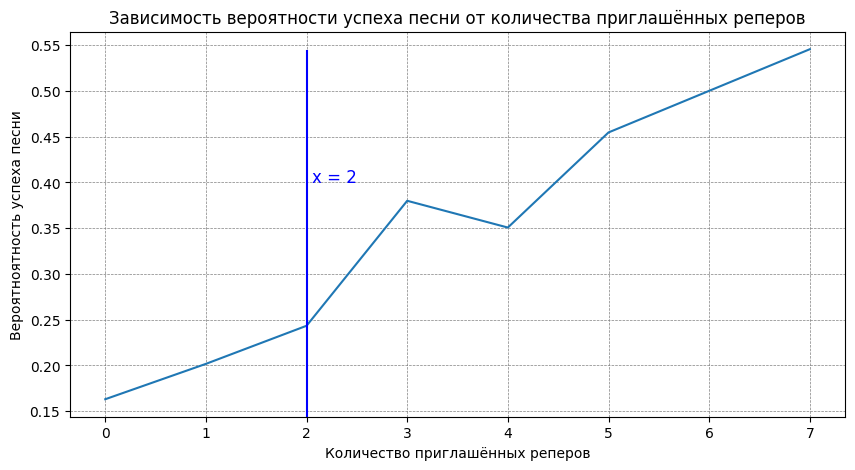

In [105]:
plt.figure(figsize = (10,5))
kek.hit.plot()
plt.title('Зависимость вероятности успеха песни от количества приглашённых реперов')
plt.xlabel('Количество приглашённых реперов')
plt.ylabel('Вероятноятность успеха песни');
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);


# линия разграничитель
plt.axvline(x=2, ymin=0, ymax=0.95, color = 'blue');
plt.text(2.5, 0.4, 'x = 2', color='blue', fontsize=12, ha='right');


Тренд был примерно понятен: с увеличением количества артистов росли шансы выдать классный мотив, это подтверждается восходящей долей в колонке hit. Однако с ростом n_feat у нас становится все меньше и меньше наблюдений, подпадающих под условие: по понятным причинам треков с большим количеством исполнителей меньше в природе.

При таком дизбалансе классов анализ будет некорректным, поэтому есть смысл сузить рассматриваемый дипазон до треков с 0 до 2 приглашенных артистов. И вот
уже по этим данным сможем сказать, что гипотеза подтвердилась.

Надо расширять выборку песнями именно с большим количеством исполнителей. А в текущих условиях можем классифицировать треки, где 3 и более исполнителей как выбросы (см график ниже).




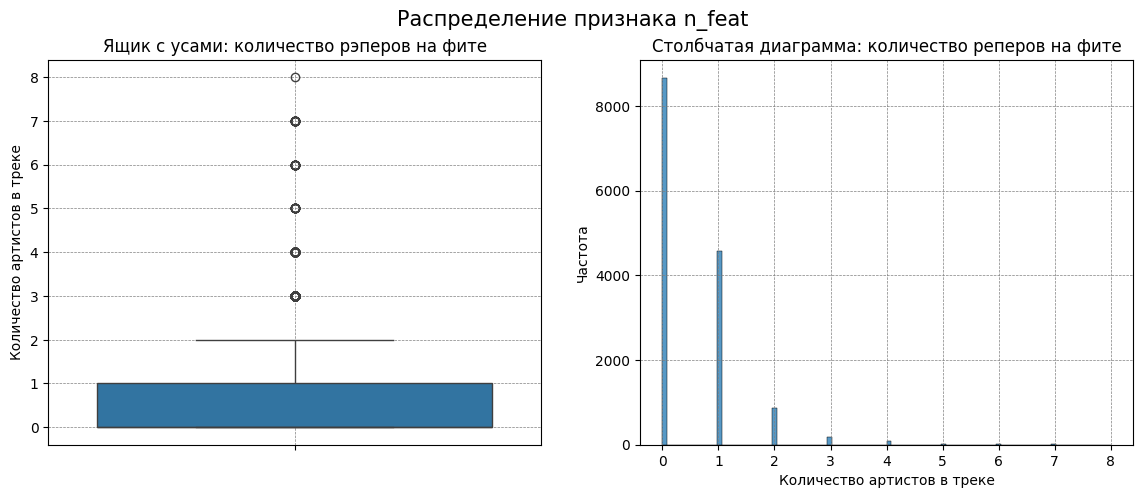

In [106]:
plt.figure(figsize=(14, 5))
plt.suptitle('Распределение признака n_feat', fontsize=15)

plt.subplot(1,2,1)
sns.boxplot(df.n_feat);
plt.title("Ящик с усами: количество рэперов на фите");
plt.ylabel("Количество артистов в треке");
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);


plt.subplot(1,2,2)
sns.histplot(x='n_feat', data=df)
plt.title('Столбчатая диаграмма: количество реперов на фите')
plt.xlabel('Количество артистов в треке')
plt.ylabel('Частота');
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);


Ящик с усами с уверенностью заявляет, что категории в признаке n_feat распределены неравномерно, видны выбросы. На гистограмме справа представлен состав колонки и частоты каждой категории в нем.

### 4) Грустный или веселый реп: что больше любит население?

In [107]:
df.mode_name.value_counts()

mode_name
minor    7237
major    7155
Name: count, dtype: int64

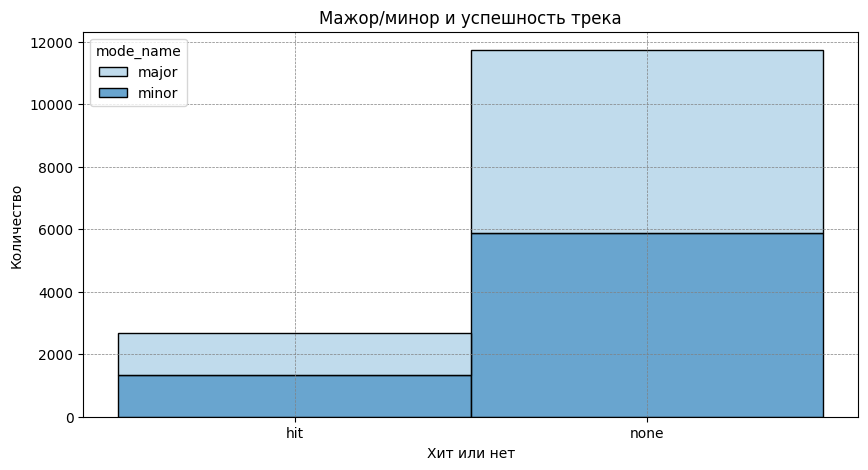

In [108]:
plt.figure(figsize = (10,5))
sns.histplot(x='Song_Success', hue = 'mode_name',data=df, palette = 'Blues', multiple = 'stack')
plt.title('Мажор/минор и успешность трека')
plt.xlabel('Хит или нет')
plt.ylabel('Количество')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

Распределение тональностей мажор/минор примерно одинаково как для популярных треков, так и для сомнительных композиций.

In [109]:
pd.DataFrame(df.groupby(by = 'mode_name').Song_Success.value_counts(normalize = True))

proportion
mode_name Song_Success            
major     none            0.816352
          hit             0.183648
minor     none            0.813597
          hit             0.186403

###5) Как время года влияет на выбор тональности слушателями

In [110]:
grouped_m = df.groupby(df['album_release_date'].dt.month)[['mode_name', 'Song_Success']]
grouped_month = grouped_m.value_counts(normalize = True).unstack()
grouped_month.head()

Song_Success                       hit      none
album_release_date mode_name                    
1                  major      0.072091  0.423275
                   minor      0.092688  0.411946
2                  major      0.095359  0.416034
                   minor      0.076793  0.411814
3                  major      0.068515  0.382545

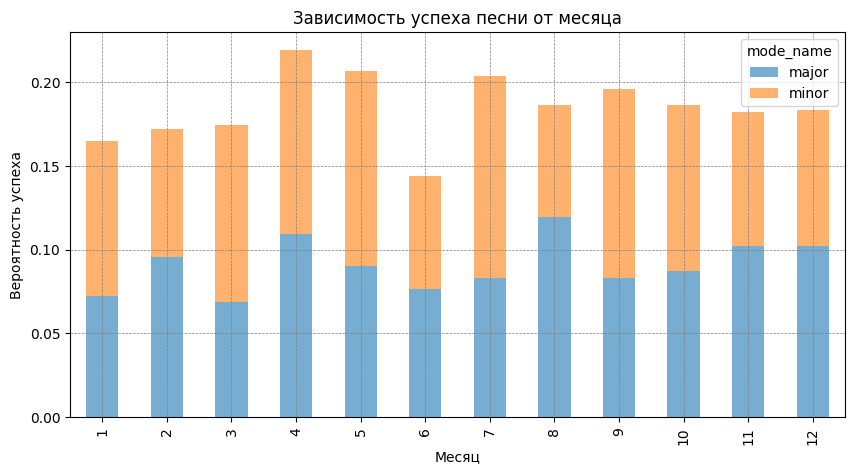

In [111]:
pd.pivot_table(grouped_month,index='album_release_date', columns='mode_name', values='hit').plot(legend= True, kind = 'bar', alpha=0.6, stacked=True, figsize=(10,5),
                                                                                                 )
plt.title('Зависимость успеха песни от месяца')
plt.ylabel('Вероятность успеха')
plt.xlabel('Месяц')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

*   Если песня выпущена в 4, 5 и 7 месяцах (апрель, май, июль), то у нее больше шансов стать популярной. Если песня выпущена в 6 месяце (июнь), то вероятность ее успеха мала.
*   Как бы странно ни было, но в июне, июле больше шансов на успех у минорных песен. А в августе лучше всего заходять мажорные композиции. Какой-то четкой закономерности по предпочтениям тональностей нет, но предпочтения варьируются.
* Песни распределены более-менее равномерно в течение года

### 5) Посмотрим на технические параметры песен, оценим их влияние на таргет Song_Success

Мы выше указывали, что рассмотрим часть признаков немного позже, момент настал. Встрчаем новых игроков:
* Drums_Energy - чем выше, тем интенсивнее ритм
* Drums_Complexity - чем выше, тем более динамичный и разнообразный ритм
* Variety_of_musical_instruments - чем выше, тем меньше инструментов используется
* Harmonic_Richness - чем выше, тем больше музыкальное разнозие мелодий
* Mixing_Character - чем выше, тем больше высоких частот в музыке, иначе - басы
* Emotional_Intensity -  чем выше, тем более расслабляющая спокойная музыка



У нас достаточно много признаков, описывающих бит, табличка по ним выведена ниже.

In [113]:
y_encoded = (df.Song_Success=='hit').astype('int') # таргет закодировали
tecnikal_info = df.select_dtypes(include = 'float64').join(y_encoded)
tecnikal_info.head()

,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,Song_Success
0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,1
1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,0
2,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,0
3,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,0
4,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,0


Вот так будет выглядеть наша матрица корреляций

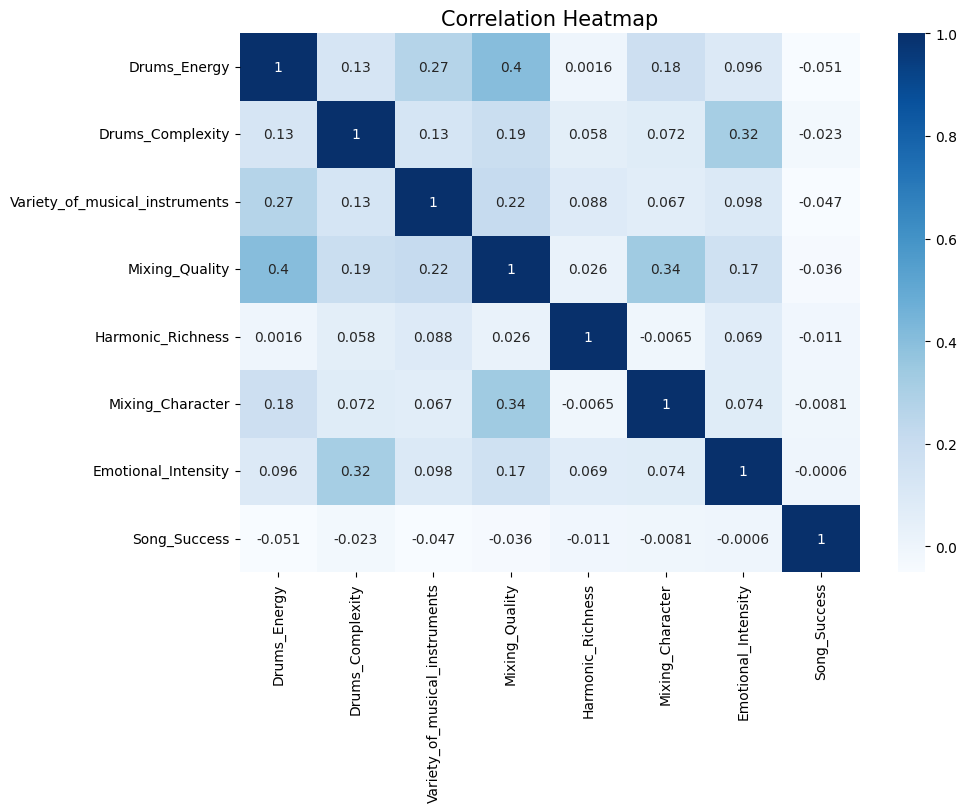

In [114]:
plt.figure(figsize = (10,7))
corr_df = sns.heatmap(tecnikal_info.corr(), cmap='Blues', annot=True, fmt='0.2g');
corr_df.set_title('Correlation Heatmap', fontsize = 15);

In [115]:
pd.DataFrame(tecnikal_info.corrwith(y_encoded), columns = ['corr with Song_Success']).T

,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,Song_Success
corr with Song_Success,-0.050908,-0.022609,-0.047288,-0.036314,-0.01062,-0.008065,-0.000603,1.0


Корреляция отрицательна по каждому признаку с таргетом (Song_Success - хит или нет), отсюда может следовать вывод, что в среднем вместе с увеличением какой-либо из этих характеристик следует снижение популярности песни. Посмотрим на средние параметры по каждой колонке признаков.



### 6) Какие средние значения характеристик для хитов и непопулярных треков?

In [116]:
pd.DataFrame(tecnikal_info.describe().iloc[:,:-1].iloc[1]).T

,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity
mean,0.972346,0.95468,0.971905,0.911228,0.967852,0.968181,0.957331


In [117]:
tecnikal_info.groupby(by = 'Song_Success').mean()

,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity
Song_Success,,,,,,,
0,0.984000,0.960191,0.982704,0.921223,0.970480,0.970115,0.957471
1,0.921015,0.930407,0.924343,0.867206,0.956279,0.959663,0.956717


Можно заметить, что средние характеристики у успешных треков (1) ниже в сравнении с теми же средними для Song_Success = 0  по всем признакам. Посмотрим на таблицу характеристик из пункта 5, все средние значения в группе неудачных треков выше чем средние по генеральной совокупности.

В итоге подтвердилась отрицательная корреляция с таргетом (см хитмэп): большие значения признаков отрицательно влияют на популярность песни. Поясним: существуют определенные звуки, которые из-за своей интенсивности или в целом специфичности характеристик тяжелы для восприятия человеком: например высокие частоты, сложные тяжелые басы, шум/скрежет/искаженные звуки и тд, неадекватные ритмы. Большая вариантивность музыкальных инструментов при неумелом сочетании может создать звуковую кашу, которую тоже станет невозможно слушать равно или поздно. Было замечено, что все средние характеристики плохих треков были выше средних значений - индикатор того, что музыку перегрузили или могли как-то иначе сделать неприятной для человеческого уха.



В среднем имеем такой расклад
* Drums_Energy - в успешных треках более умеренный барабанный бит
* Drums_Complexity - умерено динамичный ритм, чем значение выше, тем более "барабанная" музыка
* Variety_of_musical_instruments - если было использовано небольшое количество инструментов, то наблюдаем высокие значение. В успешных треках все более-менее разнообразно
* Harmonic_Richness - в успешных треках мелодии сбалансированы, чем выше значение, тем больше различных звуков использовано (в непопулярных треках перебарщивают и получается та самая каша)
* Mixing_Character - в популярны песнях больше басов, чем высоких нот
* Emotional_Intensity - чем ниже, тем грубее или агрессивнее трек. В целом тут особо нет различий в средних по популярным и не очень трекам, это видимо сказано тем, что сформировался стиль чтения рэпа

### 7) Распредление тех. характеристик и таргета

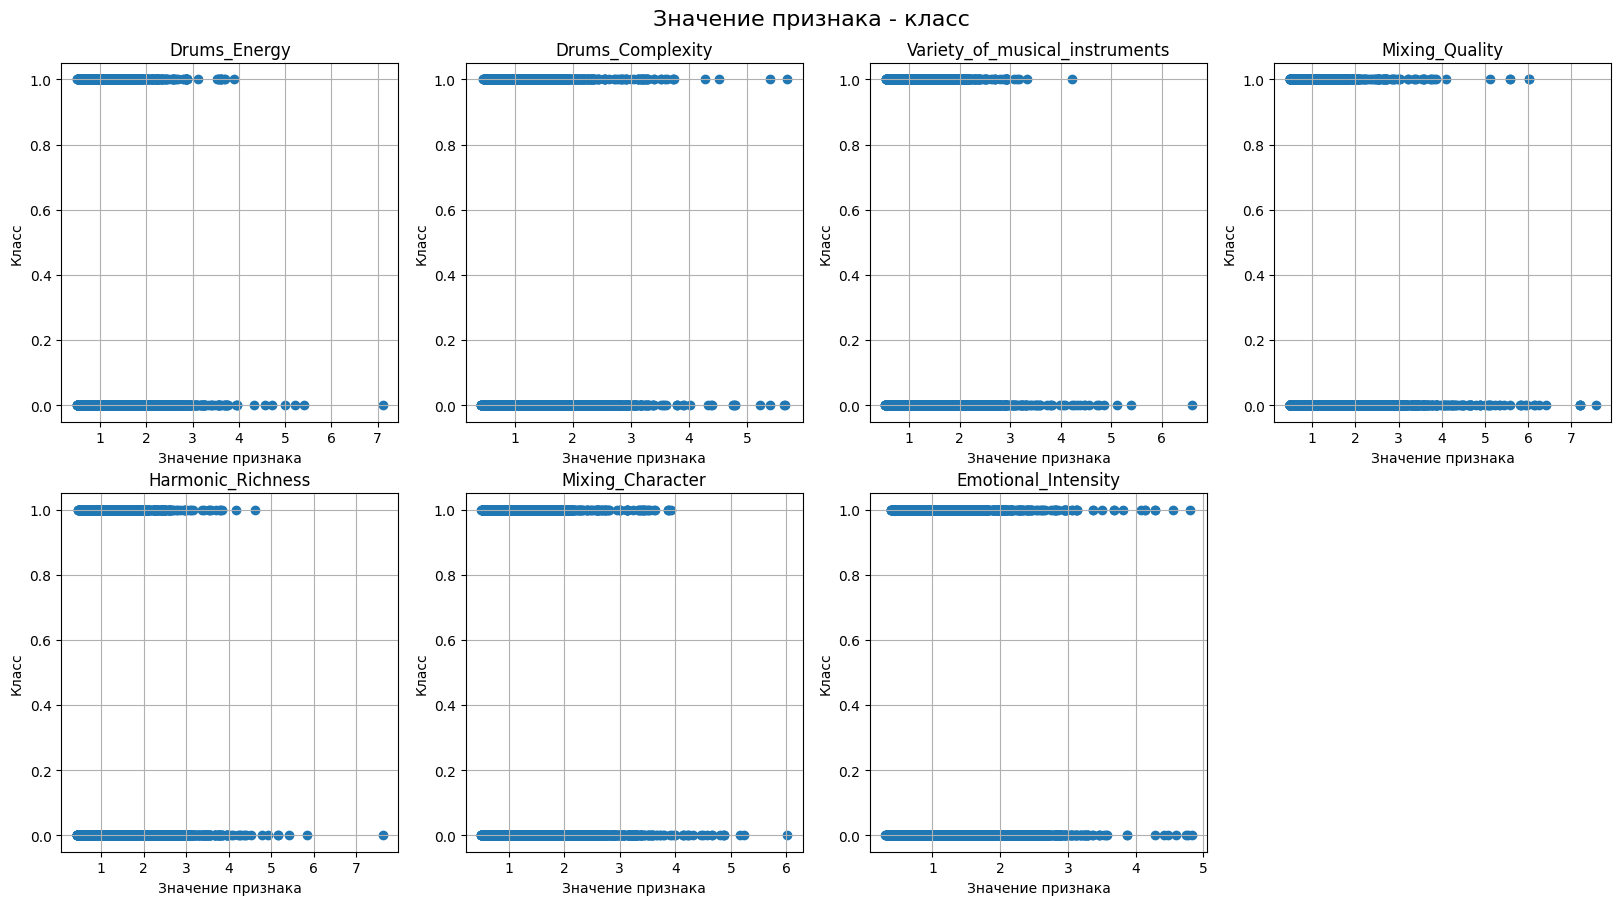

In [118]:
plt.figure(figsize=(20, 27))
plt.suptitle('Значение признака - класс', y=0.9, fontsize=16)

num = 0
for i in tecnikal_info.columns[:-1]:
    plt.subplot(5, 4, num+1)
    plt.scatter(tecnikal_info[i], tecnikal_info.Song_Success)
    plt.title(i)
    plt.xlabel('Значение признака')
    plt.ylabel('Класс')
    plt.grid()
    num += 1

Посмотрим на точечные гистограммы признак - класс. Если присмотреться, то на глаз можно выявить закономерности между таргетом и определенным признаком: например графики Drums_Energy, Variety_of_musical_instruments, Mixing_Quality, Mixing_Character показывают, что метка приобретает класс 0, если характеристики сильно завышены.


Признак Emotional_Intensity будто бы ни о чем не говорит вообще (только визуально, надо проверять важность признаков, это сделаем позже при обучении леса), практически одинаковое скопление точек как на 0, так и на 1 классах таргета в одних и тех же местах - пока кажется неинформативным.

Чаще всего реперы выбирают ненавороченные музыкальные композиции с нетяжелыми битами.

### 8) Длительность песен

<ipython-input-120-8c47cd635e69>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxes = sns.boxenplot(data = df, y = 'song_duration', x = 'Song_Success', palette = 'Blues');


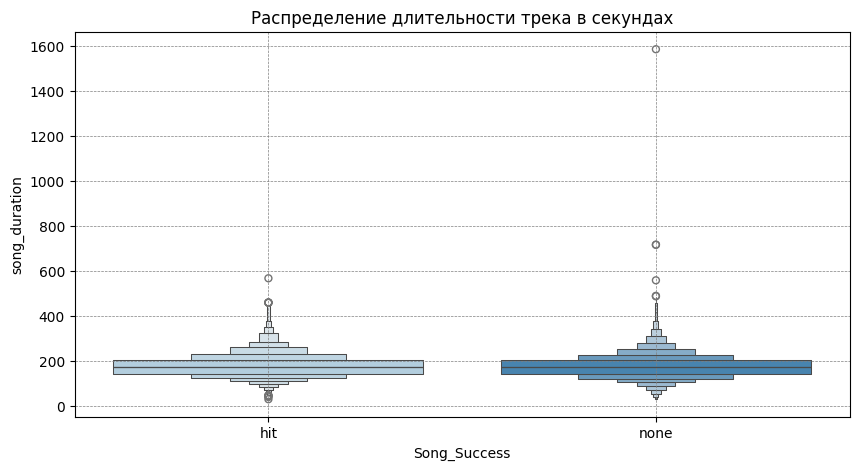

In [120]:
# общие настройки
plt.figure(figsize=(10, 5))
boxes = sns.boxenplot(data = df, y = 'song_duration', x = 'Song_Success', palette = 'Blues');
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
boxes.set(title = 'Распределение длительности трека в секундах');

Длительность песен в секундах распределена нормально, мы сделали разбивку по таргету, можем увидеть несколько выбросов как в популярных, так и в непопулярных треках. В целом распределения очень похожи для двух классов.

In [121]:
df.groupby('Song_Success').song_duration.describe()

,count,mean,std,min,25%,50%,75%,max
Song_Success,,,,,,,,
hit,2663.0,178.420203,51.67041,30.0,144.0,174.0,205.0,567.0
none,11729.0,174.707392,53.83228,30.0,140.0,172.0,204.0,1584.0


# 3. Обработка данных

### Убираем лишние признаки

Некоторые признаки были нужны для парсинга, но для пострения будущих моделей они бесполезны, поэтому удалим их. Например у нас было несколько айдишников: track_id, artist_id, album_id, ссылки для скачивания на Спотифай и тд.

In [219]:
lol = df.copy()
new_df = lol.drop(['album_name','artists_all', 'key_name', 'key_mode'], axis = 1)

### Добавляем новые

Приведем колонку album_release_date к формату "год", чтобы не плодить лишних признаков при кодировании

In [220]:
new_df.album_release_date = pd.to_datetime(new_df.album_release_date).dt.year
new_df.head()

,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,higher_guest,album_type,track_number,explicit,mode_name,remake,song_duration
0,044 ROSE,hit,2017,0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,True,1,1,single,1,True,major,original,169
1,044 ROSE,none,2017,1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,True,1,0,single,1,True,major,original,196
2,044 ROSE,none,2018,1,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,False,0,0,album,1,True,major,original,127
3,044 ROSE,none,2018,1,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,True,1,1,album,2,True,major,original,169
4,044 ROSE,none,2018,1,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,False,0,0,album,3,True,minor,original,127


Уже лучше, но нужно еще поколдовать, а именно надо разбить данные на трейн и тест и закодировать категориальные колонки. Будем использовать stratify=y, чтобы баланс классов сохранился в выборках

In [221]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [222]:
X = new_df.drop('Song_Success', axis = 1)
y = (new_df.Song_Success=='hit').astype('int') # метки классов здесь, переводим в бинарный формат

In [223]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, \
                                                     test_size=0.3,\
                                                     random_state=52, stratify=y)

Данные колонки нужно будет закодировать

In [224]:
columns_to_encode = X_train.select_dtypes(include = ['object', 'bool']).columns
columns_to_encode

Index(['artist_name', 'is_feat', 'album_type', 'explicit', 'mode_name',
       'remake'],
      dtype='object')

In [225]:
X_train.info() # здесь информация о типах данных в колонках

<class 'pandas.core.frame.DataFrame'>
Index: 10074 entries, 11710 to 8748
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   artist_name                     10074 non-null  object 
 1   album_release_date              10074 non-null  int32  
 2   hit_n                           10074 non-null  int64  
 3   Drums_Energy                    10074 non-null  float64
 4   Drums_Complexity                10074 non-null  float64
 5   Variety_of_musical_instruments  10074 non-null  float64
 6   Mixing_Quality                  10074 non-null  float64
 7   Harmonic_Richness               10074 non-null  float64
 8   Mixing_Character                10074 non-null  float64
 9   Emotional_Intensity             10074 non-null  float64
 10  is_feat                         10074 non-null  bool   
 11  n_feat                          10074 non-null  int64  
 12  higher_guest                    10

На случай, если в тесте окажутся новые категории, которых не было в трейне используем ohe из sklrn с параметром handle_unknown='ignore' для импостеров из теста. А вообще можно через пайплайн сделать, будет симпатичнее.

In [226]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_train = pd.DataFrame(ohe.fit_transform(X_train[columns_to_encode]))
ohe_test = pd.DataFrame(ohe.transform(X_test[columns_to_encode]))

feature_names = ohe.get_feature_names_out(columns_to_encode) # хочу чтобы закодированные колонки имели имена
ohe_train.columns, ohe_test.columns = feature_names,  feature_names

ohe_train.index = X_train.index # индексацию пофиксили, иначе будут наны
ohe_test.index = X_test.index

X_train,X_test = X_train.drop(columns_to_encode, axis=1), X_test.drop(columns_to_encode, axis=1) # удаляем те столбцы, которые кодировали

X_train, X_test = pd.concat([X_train, ohe_train], axis=1), pd.concat([X_test, ohe_test], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [227]:
X_train.shape

(10074, 307)

# Строим модели

Мы обучим несколько моделей для задач классификации, а в конце сравним полученные результаты.

### Бэггинг: 50 деревьев

Будем решать задачу классификации песен, а именно прогнозировать является ли трек популярным или нет. Обучаем 50 деревьев на подвыборках, модель композиция выдает прогноз по методу голосования большинства, в задачах классификации - ответ на объекте - мода ответов 50 базовых моделей.

In [170]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

In [171]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(random_state = 42, n_estimators=50)
bag.fit(X_train, y_train)

y_test_pred_bag = bag.predict(X_test)

In [172]:
y_test_pred_bag

array([0, 0, 0, ..., 0, 0, 0])

In [174]:
print(classification_report(y_test, y_test_pred_bag))
print(f'Roc-auc score bagging: {roc_auc_score(y_test, y_test_pred_bag)}')

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3519
           1       0.67      0.39      0.49       799

    accuracy                           0.85      4318
   macro avg       0.77      0.67      0.70      4318
weighted avg       0.84      0.85      0.84      4318

Roc-auc score bagging: 0.6733628388142182


Мы хотим добиться хорошей модели-композии, поэтому строим сложные глубокие деревья, они должны оказаться переобученными, а усреднение предсказаний по всем 50 базовым моделям даст нужный результат - мы получим весьма сносную модель с низким разбросом и смещением. Поэтому все признаки были оставлены именно для бэггинга.




### Выбираем лучшие признак

Ниже мы будем обучать случайный лес, это комбинация из бэггина и метода случайных подпространств - происходит рандомный отбор признаков и обучение дерева на них. Лес так же случайно может отбирать мало информативные характеристики, а если у нас их будет много, то можем на выходе получать слабые деревья и как следствие слабуя композицию.

Признаков у нас много, а все ли из них имеют смысл? Сейчас проверим, посмотрим на дисперсии наших маленьких друзей, поищем среди них константные, а то есть "плохие" признаки.

In [228]:
from sklearn.feature_selection import VarianceThreshold

In [229]:
features_variance = X_train.var().sort_values(ascending=False)
features_variance[-10:]

artist_name_semmmyq                0.000298
artist_name_Jakone                 0.000199
artist_name_uglystephan archive    0.000199
artist_name_Sqweezey               0.000199
artist_name_Грибы                  0.000099
artist_name_Dina RAF               0.000099
artist_name_babyswishh1            0.000099
album_type_compilation             0.000099
artist_name_bratishkin             0.000099
artist_name_nevroz                 0.000099
dtype: float64

Действительно, есть бесполезные признаки, они могут усложнить работу нашей модели в дальнейшем, поэтому сейчас будем отбирать только самых достойных кандидатов.


In [230]:
vs_transformer = VarianceThreshold(0.02)

X_train_rf = pd.DataFrame(
    data=vs_transformer.fit_transform(X_train),
    columns=X_train.columns[vs_transformer.get_support()],
)
X_test_rf = pd.DataFrame(
    data=vs_transformer.transform(X_test),
    columns=X_test.columns[vs_transformer.get_support()],
)

In [231]:
X_train_rf.shape # уменьшили в 10 раз

(10074, 24)

### Случайный лес, случайный лес

Нужно найти оптимальные параметры для нашего дерева - глубину и мнимальное количество элементов для формирования листа

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [208]:
param_grid = {'max_depth': [6, 8, 10, 12],
              'min_samples_split': [2, 5, 8, 10]}


rf = RandomForestClassifier(n_estimators=50, random_state = 42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_rf, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [209]:
best_params

{'max_depth': 12, 'min_samples_split': 5}

In [212]:
best_model_rf = RandomForestClassifier(n_estimators=50, **best_params, random_state=42)
best_model_rf.fit(X_train_rf, y_train)
y_test_pred_rf = best_model_rf.predict(X_test_rf)

In [213]:
print(classification_report(y_test, y_test_pred_rf))
print(f'Roc-auc score RandomForest: {roc_auc_score(y_test, y_test_pred_rf)}')

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      3519
           1       0.74      0.31      0.43       799

    accuracy                           0.85      4318
   macro avg       0.80      0.64      0.67      4318
weighted avg       0.84      0.85      0.83      4318

Roc-auc score RandomForest: 0.6407556547133192


Посмотрим на топ признаков по важности по мнению случайного леса:

In [214]:
kek = best_model_rf.feature_importances_
index = np.argsort(kek)[-10:]

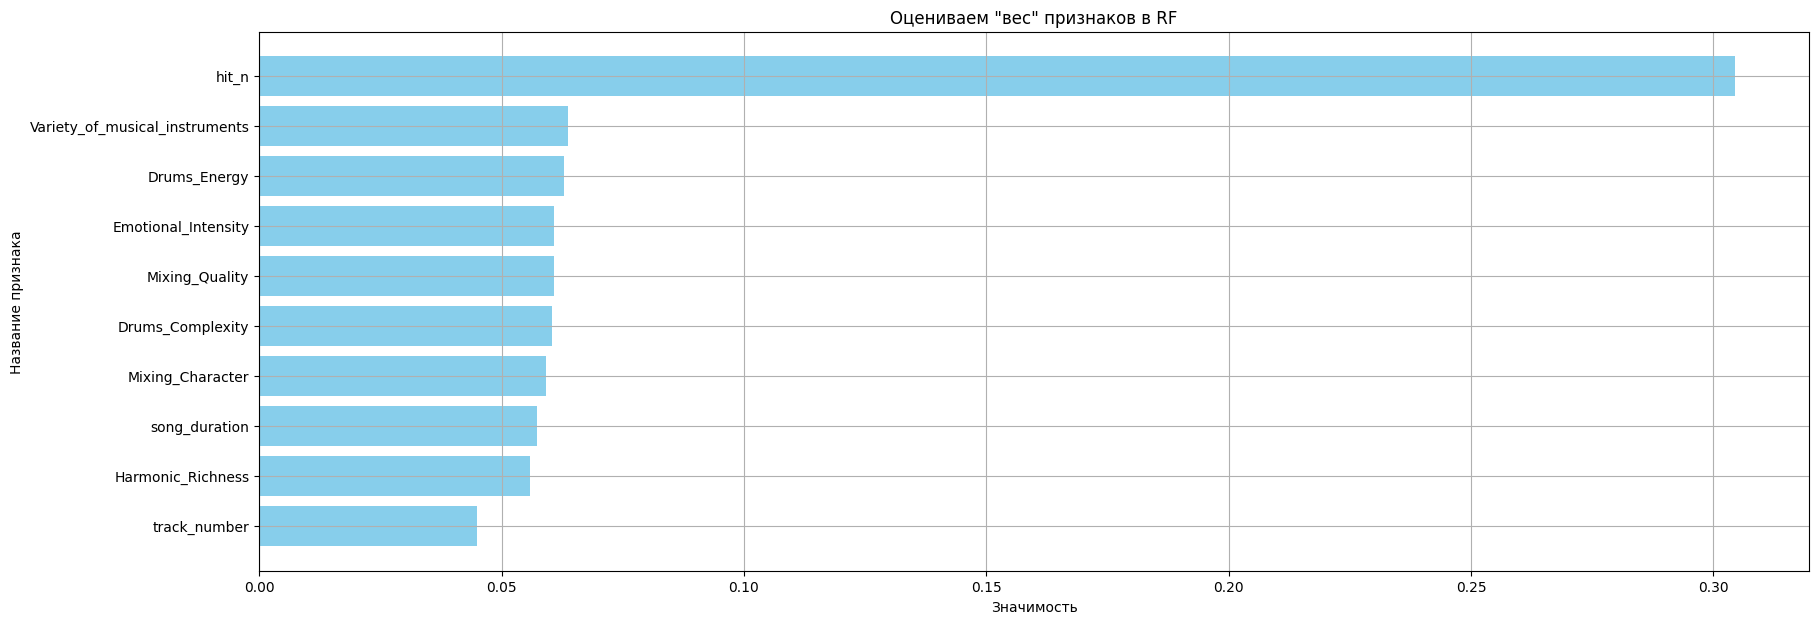

In [215]:
plt.figure(figsize=(20, 7))
plt.barh(X_train.columns[index], kek[index], color='skyblue')

plt.ylabel('Название признака')
plt.xlabel('Значимость')
plt.title('Оцениваем "вес" признаков в RF')
plt.grid()

Выше на графике случайный лес отранжировал признаки по важности: топ 1 - количество ранее выпущенных треков у артиста - явный лидер, далее видим ряд из. признаков с примерно одинаковым весом: большое внимание уделяется характеристикам музыки: разнообразие мелодии и музыкальных инстурментов, наличие барабанной дроби и тд. Из интересного - сюда попали длительность песни и номер трека в альбоме.

### Логистическая регрессия

In [232]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [233]:
scaller = MinMaxScaler()
columns = X_train.columns
X_train_lr = pd.DataFrame(scaller.fit_transform(X_train), columns = columns)
X_test_lr = pd.DataFrame(scaller.transform(X_test),columns = columns)

lr = LogisticRegression(random_state=42, max_iter=400)
lr.fit(X_train_lr, y_train)

y_pred_lr = lr.predict(X_test_lr)
print(classification_report(y_test, y_pred_lr))
print(f'Roc-auc score LogisticRegression: {roc_auc_score(y_test, y_pred_lr)}')

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3519
           1       0.67      0.35      0.46       799

    accuracy                           0.85      4318
   macro avg       0.77      0.66      0.69      4318
weighted avg       0.83      0.85      0.83      4318

Roc-auc score LogisticRegression: 0.6558953522821401




---


Результаты трех моделей:

In [236]:
results = pd.DataFrame({"Модель": ["Бэггинг", "Run, Forest!", "Лог. рег"],
                       'Roc-auc': [roc_auc_score(y_test, y_test_pred_bag), roc_auc_score(y_test, y_test_pred_rf), roc_auc_score(y_test, y_pred_lr)]})
results.round(3)

,Модель,Roc-auc
0,Бэггинг,0.673
1,"Run, Forest!",0.641
2,Лог. рег,0.656


### Номер трека в альбом - интересный признак?

Text(0.5, 0, 'Номер трека')

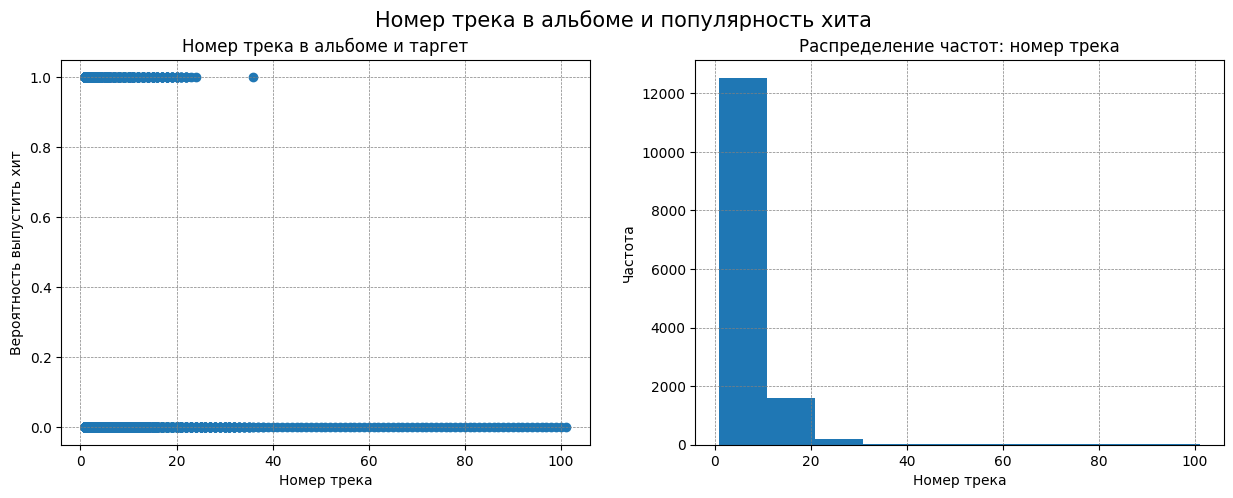

In [235]:
plt.figure(figsize=(15, 5))
plt.suptitle('Номер трека в альбоме и популярность хита', fontsize=15)

plt.subplot(1,2,1)
plt.scatter(X.track_number, y)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);
plt.title('Номер трека в альбоме и таргет')
plt.xlabel('Номер трека')
plt.ylabel('Вероятность выпустить хит');


plt.subplot(1,2,2)
plt.hist(X.track_number)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);
plt.title('Распределение частот: номер трека');
plt.ylabel('Частота');
plt.xlabel('Номер трека')

На графике слева хорошо видны различия в распределении признака для популярных треков. Все наблюдения выше +-25 можно классифицировать как плохие демки. Да, вещь полезная

# Мемное собрание


### подборо4ка


<img src = 'https://sun9-34.userapi.com/impg/7Stgu8swv7_3sTlkJ014sPKLtyIFPoz71jA20Q/6-FrpK4cIG4.jpg?size=1200x940&quality=95&sign=17e862859d5a0a4d4a5776d5537e2a0f&type=album' width = 500>



<img src = 'https://sun1-92.userapi.com/impg/_0Xx0ytGFYpk66DvZ3MdmLgG0V_KBdEW5pOKug/EYLAFZNBinw.jpg?size=868x1000&quality=96&sign=5a0de68b7e1524fb33dc336afa890b1e&type=album' width = 500>